<h1 style="font-size:30px;">Americal Sign Language (ASL) - Dataset Overview</h1>  

The Kaggle ASL data set is a collection of images of alphabets from the American Sign Language, separated in 29 folders which represent the various classes.



## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset Overview](#3-Dataset-Oveview)
* [4 Dataset Configuration](#4-Dataset-Configuration)
* [5 Dataset Preparation](#4-Dataset-Preparation)
* [6 Conclusion](#6-Conclusion)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42 

## 1 System Configuration

In [2]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


## 2 Download and Extract the Dataset

In [3]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [4]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [5]:
# We are on Kaggle, no need to download the data set.
# Simply add dataset to notebook with "Add Data" button on right

dataset_path = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'


## 3 Dataset Overview

This section will explore the ASL dataset.

### 3.1 Dataset Directory Structure

This section takes a look at how the images and folders are structured. 
This will be of particular importance when using `image_dataset_from_directory()`. 


```
input
└── asl-alphabet
    └── asl_alphabet_train
        └── asl_alphabet_train
            ├── A
            ├── B
            ├── C
            ├── ...
            ├── X
            ├── Y
            ├── Z
            ├── {del}
            ├── {nothing}
            └── {space}

```

In [6]:
# Class names.
class_names = sorted([f for f in os.listdir(dataset_path) if not f.startswith('.')])

for i in range(len(class_names)):
    print(i, class_names[i])

0 A
1 B
2 C
3 D
4 E
5 F
6 G
7 H
8 I
9 J
10 K
11 L
12 M
13 N
14 O
15 P
16 Q
17 R
18 S
19 T
20 U
21 V
22 W
23 X
24 Y
25 Z
26 del
27 nothing
28 space


### 3.2 Display one Image for each Class

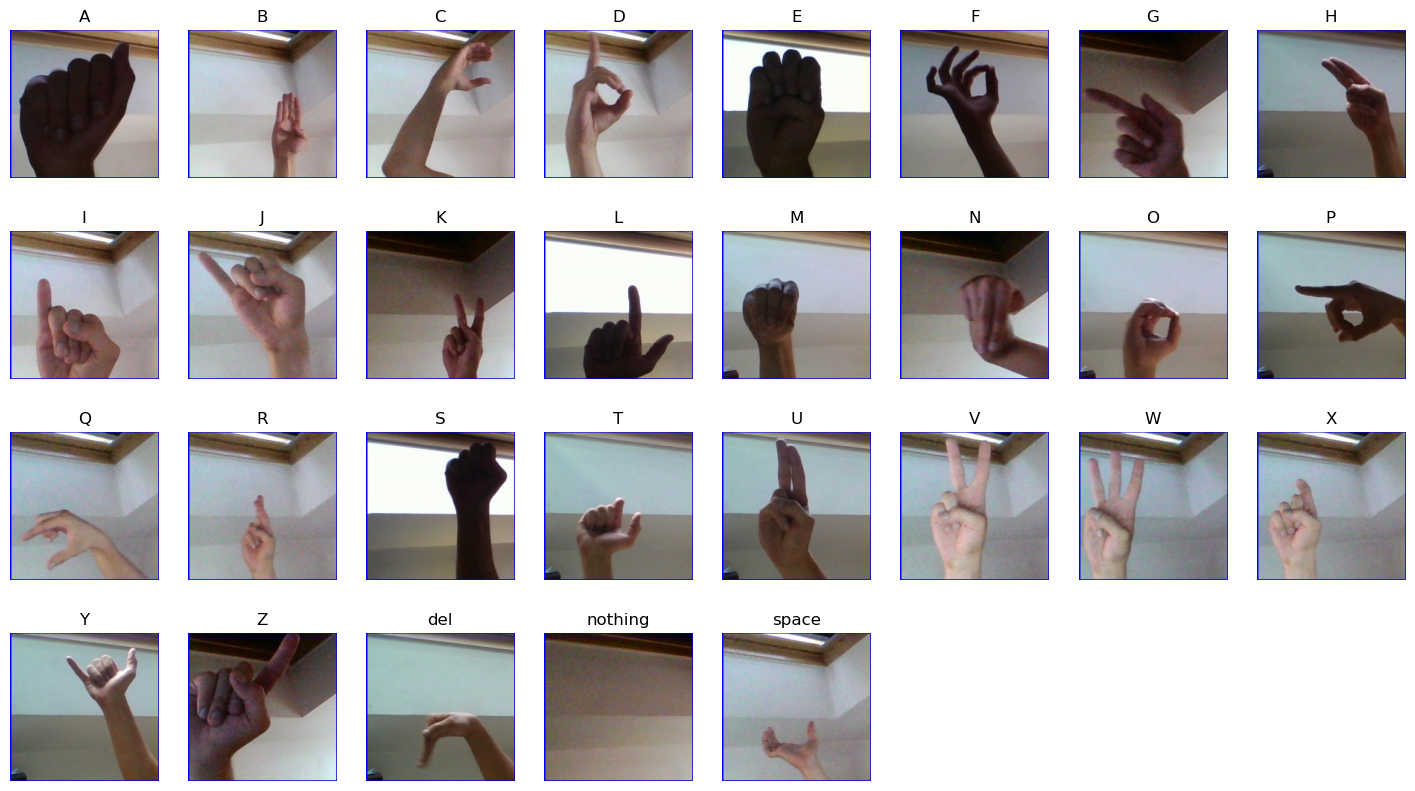

In [7]:
plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

for i in range(len(class_names)):
    
    image_paths = glob.glob(f"{dataset_path}/{class_names[i]}/*", recursive=True)

    random_idx = random.choice(list(range(0, len(image_paths))))
    image = plt.imread(image_paths[random_idx])
    
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image)
    plt.title(class_names[i])
    plt.axis("off")


### 3.3 Display Class Histogram

We want to ensure that the dataset is balanced.  A balanced dataset will have the same number of data for each class.

In [8]:
for i in range(len(class_names)):
    
    image_paths = glob.glob(f"{dataset_path}/{class_names[i]}/*", recursive=True)
    num_images = len(image_paths)

    print(i, class_names[i], num_images)    


0 A 3000
1 B 3000
2 C 3000
3 D 3000
4 E 3000
5 F 3000
6 G 3000
7 H 3000
8 I 3000
9 J 3000
10 K 3000
11 L 3000
12 M 3000
13 N 3000
14 O 3000
15 P 3000
16 Q 3000
17 R 3000
18 S 3000
19 T 3000
20 U 3000
21 V 3000
22 W 3000
23 X 3000
24 Y 3000
25 Z 3000
26 del 3000
27 nothing 3000
28 space 3000


### 3.4 Visualize Data

We want to visualize the dataset to check for anything unusual.

In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)

# Display function
# ================
def view(button):
    display_handle=display(None, display_id=True)

    for i in range(len(class_names)):
    
        image_paths = sorted(glob.glob(f"{dataset_path}/{class_names[i]}/*", recursive=True))

        for j in range(0, len(image_paths)):
            image = plt.imread(image_paths[j])    
    
            _, frame = cv2.imencode('.jpeg',image)
            display_handle.update(Image(data=frame.tobytes()))
                
            if stopButton.value==True:
                cap.release()
                display_handle.update(None)                

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

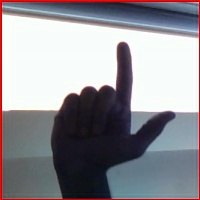

In [10]:
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

## 4 Dataset Configuration

In [11]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 29
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 64
    DATA_ROOT:   str = dataset_path

## 5 Dataset Preparation

### 5.1 Prepare the Dataset with `image_dataset_from_directory`

In [12]:
asl_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=32,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                           )


Found 87000 files belonging to 29 classes.


### 5.2 Display Sample Images

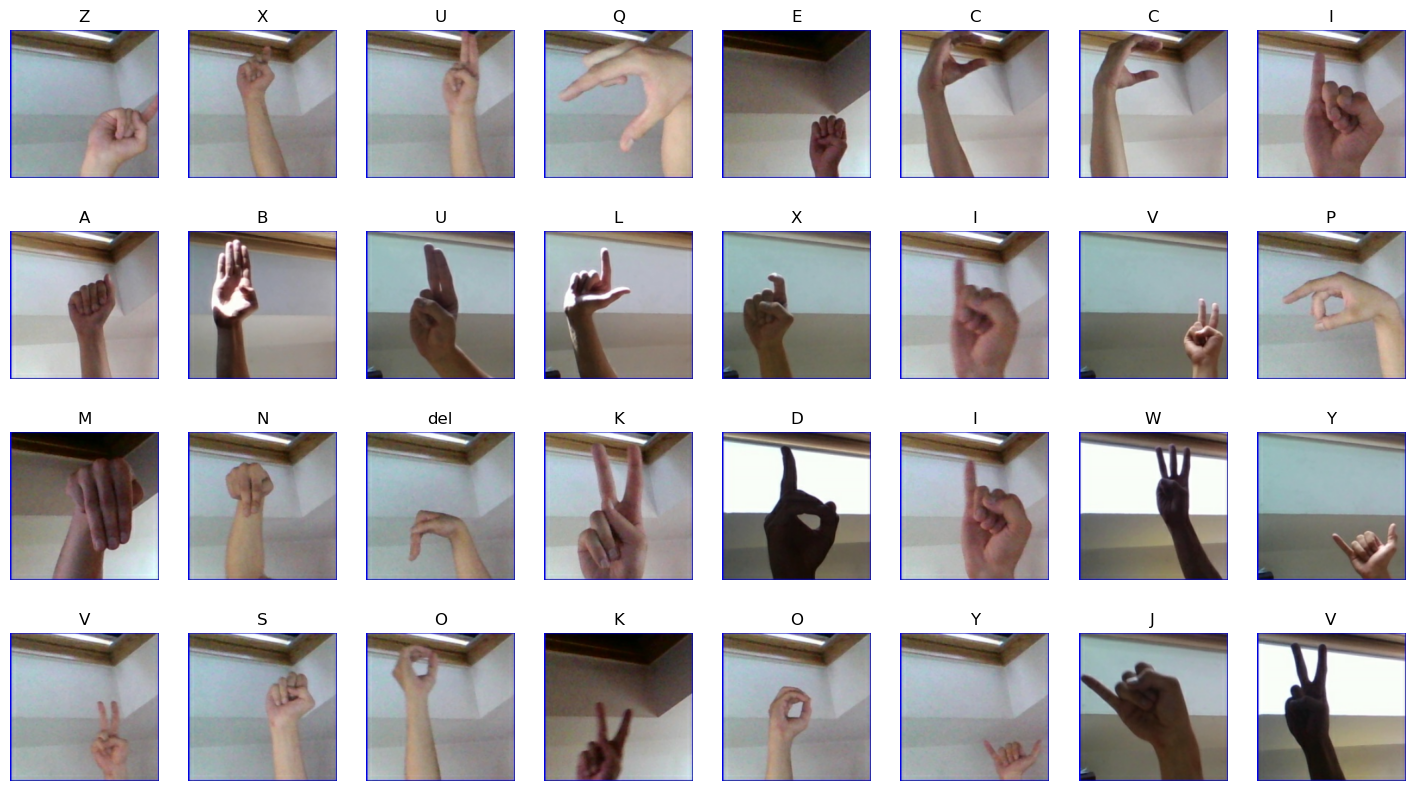

In [13]:
class_names = asl_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in asl_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

## 6 Conclusion

In this notebook, we discovered the Kaggle ASL Dataset. 